In [1]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


---
# Import Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import contractions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier

---
# 1. Road and Explore Dataset

In [3]:
# Load the dataset
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [4]:
# Display the dataset
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
133263,c8f803459a9c41ca,It's spelled ROGUE \nWhy am I triple-plussed u...,0,0,0,0,0,0
108889,4626ce272de9dfb1,I made a legitimate response to a DYN nominati...,0,0,0,0,0,0
23949,3f3d091802e22cc0,Are you a middle school student?,0,0,0,0,0,0
9717,19bb7e332324872a,"""\n\nPlease review WP:CIVIL specifically, """"Ta...",0,0,0,0,0,0
72457,c1e5f6dce863a2fc,"Betty, Bakhshi is clearly not willing to compr...",0,0,0,0,0,0


In [5]:
# Overview of datasets structure, column data types, non-null counts.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


---
# 2. Define Offensive Word Patterns (Regex) for Text Cleaning

In [6]:
# Define common offensive words with regex patterns
offensive_patterns = {
    "fuck": r"\b[f|ph|_|*][\W_]*[u|*|@|_][\W_]*[c|k|*|_][\W_]*[k|*|_](?:[e|*|r|_|*|s|ing]*)?\b",
    "shit": r"\b[s|$|5][\W_]*[h|*][\W_]*[i|!|*|1][\W_]*[t|*|+]\b",
    "bitch": r"\b[b|*|8][\W_]*[i|!|1|*][\W_]*[t|*][\W_]*[c|*][\W_]*[h|*](?:[s|*]*)?\b",
    "asshole": r"\b[a|@][\W_]*[s|$|*][\W_]*[s|$|*|5][\W_]*[h|*][\W_]*[o|0|*][\W_]*[l|*|1][\W_]*[e|*]\b",
    "cocksucker": r"\b[c|k][\W_]*[o|0][\W_]*[c|*][\W_]*[k|*][\W_]*[s|$][\W_]*[u|*][\W_]*[c|*][\W_]*[k|*][\W_]*[e|*][\W_]*[r|*]\b",
    "motherfucker": r"\b[m|*][\W_]*[o|0][\W_]*[t|*][\W_]*[h|*][\W_]*[e|*][\W_]*[r|*][\W_]*[f|ph][\W_]*[u|*|@][\W_]*[c|*][\W_]*[k|*][\W_]*[e|*][\W_]*[r|*]\b",
    "slut": r"\b[s|$][\W_]*[l|*][\W_]*[u|*][\W_]*[t|*]\b",
    "whore": r"\b[w|h|#][\W_]*[o|0|*][\W_]*[r|*][\W_]*[e|*]\b",
    "punk": r"\b[p|*][\W_]*[u|*][\W_]*[n|*][\W_]*[k|*]\b",
    "crap": r"\b[c|*][\W_]*[r|*][\W_]*[a|@][\W_]*[p|*]\b",
    "loser": r"\b[l|*][\W_]*[o|0|*][\W_]*[s|$][\W_]*[e|*][\W_]*[r|*]\b",
    "gay": r"\b[g|*][\W_]*[a|@][\W_]*[y|*]\b",
    "retarded": r"\b[r|*][\W_]*[e|*][\W_]*[t|*][\W_]*[a|@][\W_]*[r|*][\W_]*[d|*][\W_]*[e|*][\W_]*[d|*]\b",
    "dumb": r"\b[d|*][\W_]*[u|*][\W_]*[m|*][\W_]*[b|*]\b",
    "freak": r"\b[f|*][\W_]*[r|*][\W_]*[e|*][\W_]*[a|@][\W_]*[k|*]\b",
    "kill": r"\b[k|*][\W_]*[i|!][\W_]*[l|*|!][\W_]*[l|*|!]\b",
    "die": r"\b[d|*][\W_]*[i|!][\W_]*[e|*|3]\b",
    "hate": r"\b[h|*|#][\W_]*[a|@][\W_]*[t|*|+][\W_]*[e|*]\b",
    "ugly": r"\b[u|*][\W_]*[g|*][\W_]*[l|*][\W_]*[y|*]\b",
    "nerd": r"\b[n|*][\W_]*[e|*|3][\W_]*[r|*][\W_]*[d|*]\b",
    "sex": r"\b[s|5|$][\W_]*[e|3|*][\W_]*[x|*]\b",
    "dick": r"\b[d|*][\W_]*[i|!][\W_]*[c|*][\W_]*[k|*]\b",
    "fat": r"\b[f|*][\W_]*[a|@][\W_]*[t|*]\b",
    "stupid": r"\b[s|$|*][\W_]*[t|*|+][\W_]*[u|*][\W_]*[p|*][\W_]*[i|!][\W_]*[d|*]\b",
    "boobs": r"\b[b|8][\W_]*[o|0|*][\W_]*[o|0|*][\W_]*[b|8][\W_]*[s|$]\b",
    "nipple": r"\b[n|*][\W_]*[i|!|1][\W_]*[p|*][\W_]*[p|*][\W_]*[l|*|1][\W_]*[e|*]\b",
    "moron": r"\b[m|*][\W_]*[o|0][\W_]*[r|*][\W_]*[o|0|*][\W_]*[n|*]\b",
    "nigga": r"\b[n|*][\W_]*[i|1|!][\W_]*[g|*][\W_]*[g|*][\W_]*[a|@]\b"
}

---
# 3. Data Pre-processing

* Missing Values
* Convert text to lowercase
* Remove mentions (usernames starting with '@')
* Remove URLs
* Expand contractions
* Replace masked offensive words
* Clean up any remaining unwanted characters
* Remove numerical values using regex
* Count words in each column (after cleaning)
* Remove rows with more than 250 words
* Sum of tags for each row (comment)

In [7]:
# Check for missing values and drop any null rows
train_df = train_df.dropna(subset=['comment_text'])

In [8]:
# Text Cleaning

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove mentions (usernames starting with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Expand contractions
    text = contractions.fix(text)
    
    # Replace masked offensive words
    for word, pattern in offensive_patterns.items():
        text = re.sub(pattern, word, text)  # Substitute masked word with original

    # Clean up any remaining unwanted characters
    text = re.sub(r'\W+', ' ', text)
    text = text.strip()

    # Remove numerical values using regex
    text = re.sub(r'\d+', '', text)  # Removes all digits

    return text

train_df['cleaned_text'] = train_df['comment_text'].apply(clean_text)

In [9]:
# Count words in each column (after cleaning)
train_df['word_count'] = train_df['cleaned_text'].apply(lambda x: len(x.split()))

In [10]:
# Remove rows with more than 250 words
train_df = train_df[train_df['word_count'] <= 250]

In [11]:
# Sum the tags for each row (comment)
train_df.loc[:, 'tag_count'] = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)

In [12]:
# Updated dataset
train_df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,word_count,tag_count
25869,44745ba60e82a512,"""\n\nThe """"country"""" section in the infobox\nI...",0,0,0,0,0,0,the country section in the infobox i think thi...,43,0
71014,be110535c0aa1691,"""Well, yes. Sorry, as a non-expert, non-German...",0,0,0,0,0,0,well yes sorry as a non expert non german spea...,238,0
124029,975a4681ec779f6a,I use coord template with decimal parameters a...,0,0,0,0,0,0,i use coord template with decimal parameters a...,49,0
9018,17ff49f1bac84fa6,"Yeah, I think that's a five. Thanks for the re...",0,0,0,0,0,0,yeah i think that is a five thanks for the reply,11,0
26228,4564596859ce8045,The Above Info \n\nMy friend Ketchuphed is a l...,0,0,0,0,0,0,the above info my friend ketchuphed is a littl...,33,0
69833,bacf1d1ef0dc32a6,"And then the following exchange, in which I an...",0,0,0,0,0,0,and then the following exchange in which i ans...,75,0
97092,0776bc41e4e8f7f3,The article features sourced quotes from the a...,0,0,0,0,0,0,the article features sourced quotes from the a...,19,0
119821,80c55d017652bf64,"I don't see it that way. As an admin, I've alr...",0,0,0,0,0,0,i do not see it that way as an admin i have al...,78,0
89154,ee891fa43e5bcf6e,This page was improperly moved. You should go ...,0,0,0,0,0,0,this page was improperly moved you should go t...,29,0
142792,fba5a4e3ab6ad28d,DuckDuckGo svg logo \n\nNow that DuckDuckGo ha...,0,0,0,0,0,0,duckduckgo svg logo now that duckduckgo has a ...,19,0


---
# 4. Exploratory Data Analysis (EDA) - Visualization

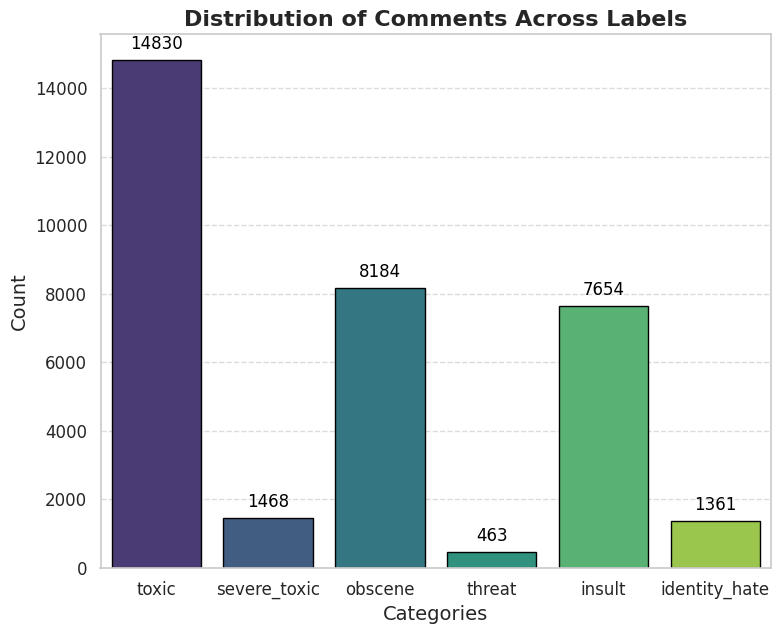

In [13]:
# Distribution of Comment Labels

# Set a style for the plot
sns.set(style="whitegrid")

# Visualize the distribution of the target labels
plt.figure(figsize=(8, 6.5))
barplot = sns.barplot(
    x=train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().index,
    y=train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().values,
    palette='viridis', edgecolor='black'
)

# Add counts on top of each bar
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=12, color='black', 
                     xytext=(0, 5),  # Adjusts the position of the text
                     textcoords='offset points')

# Enhance title and labels
plt.title("Distribution of Comments Across Labels", fontsize=16, fontweight='bold')
plt.ylabel("Count", fontsize=14)
plt.xlabel("Categories", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

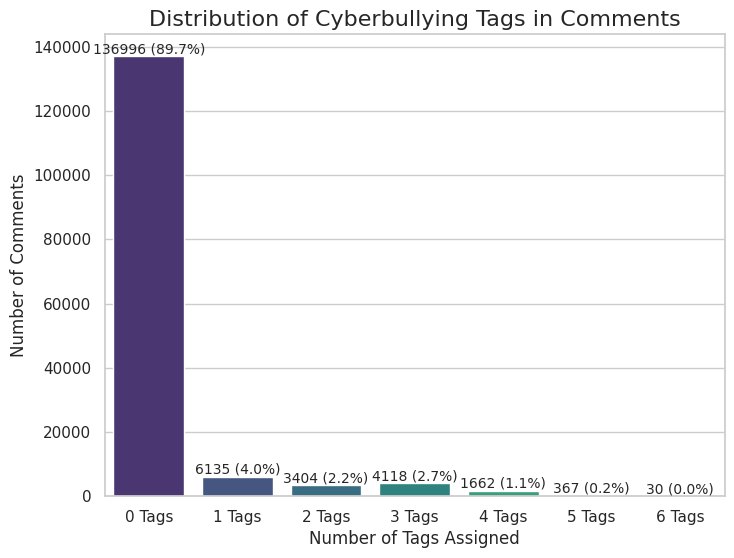

In [14]:
# Value counts for how many comments have 0, 1, 2, etc. tags
rowsums = train_df['tag_count'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(8, 6))

# Use a distinct color palette, e.g., 'Blues' for a pleasant look
ax = sns.barplot(x=rowsums.index, y=rowsums.values, palette='viridis')

# Set titles and labels
plt.title("Distribution of Cyberbullying Tags in Comments", fontsize=16)
plt.ylabel('Number of Comments', fontsize=12)
plt.xlabel('Number of Tags Assigned', fontsize=12)
# Improve x-axis labels for clarity
ax.set_xticklabels([f'{x} Tags' for x in rowsums.index])

# Step 4: Add percentages on top of bars for better context
total_comments = train_df.shape[0]
for rect, label in zip(ax.patches, rowsums.values):
    height = rect.get_height()
    percentage = (height / total_comments) * 100
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, f'{label} ({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=10)

plt.show()

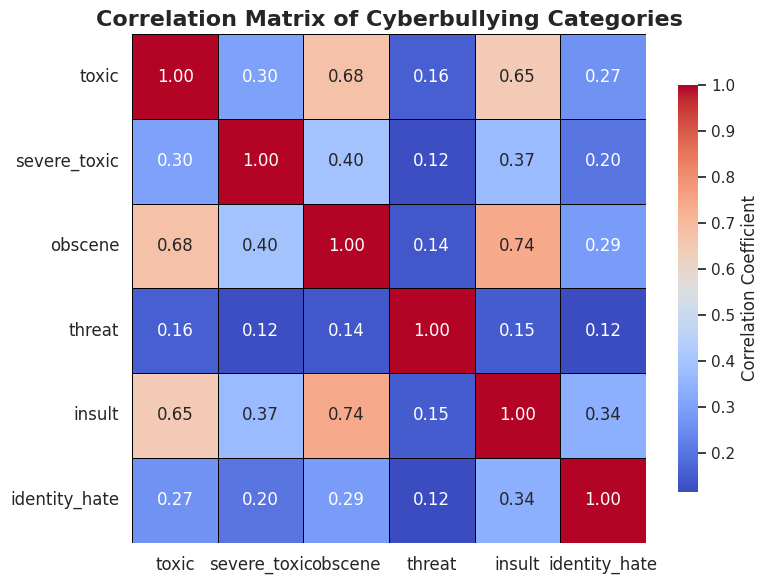

In [15]:
# Correlation
plt.figure(figsize=(8, 6))
correlation_matrix = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", 
                      cbar_kws={"shrink": .8, 'label': 'Correlation Coefficient'}, 
                      linewidths=.5, linecolor='black')

# Enhance title and labels
plt.title("Correlation Matrix of Cyberbullying Categories", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

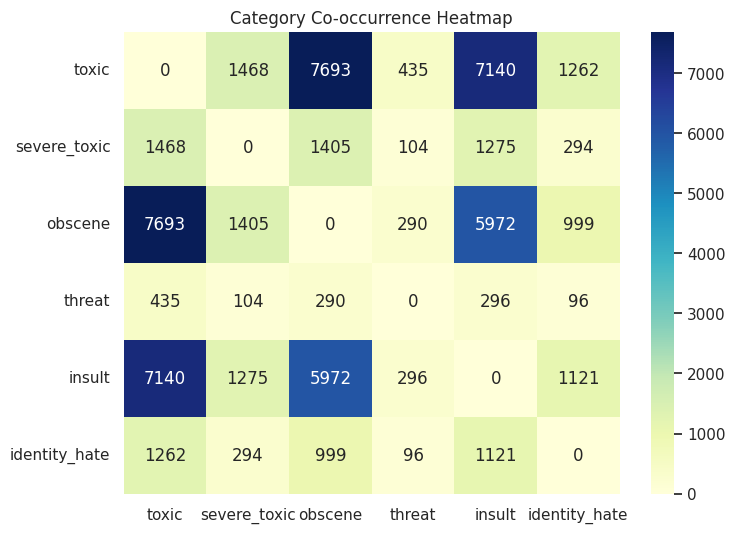

In [16]:
category_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create a co-occurrence matrix by transposing and dot product
co_occurrence_matrix = train_df[category_columns].T.dot(train_df[category_columns])

# Optional: Remove diagonal (self-correlation) for a cleaner plot
np.fill_diagonal(co_occurrence_matrix.values, 0)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_matrix, annot=True, cmap="YlGnBu", fmt="d", cbar=True)
plt.title("Category Co-occurrence Heatmap")
plt.show()

---
# 5. Preparing Data for Model Training

In [17]:
# Define feature and target variables
X = train_df['cleaned_text']
y = train_df[['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']]

In [18]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Vectorize the text data using TF-IDF
tfidf_vect = TfidfVectorizer(max_features=15000)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

---
# 6. Model Training - OneVsRest Classifier with Logistic Regression

In [20]:
# Initialize the OneVsRest classifier with Logistic Regression
model = OneVsRestClassifier(LogisticRegression(C=1, max_iter=1000))

# Train the model
model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1, max_iter=1000))

---
# 7. Model Evaluation

In [21]:
# Predict on the test set for all labels
y_pred = model.predict(X_test_tfidf)

In [22]:
# Evaluate the model for each label
results = []
for idx, label in enumerate(y.columns):
    # Calculate and print accuracy for each label
    accuracy = accuracy_score(y_test[label], y_pred[:, idx])
    results.append({"Label": label, "Accuracy": f"{accuracy:.4f}"})
    
    # Print classification report for each label
    print(f"Classification report for {label}:")
    print(classification_report(y_test[label], y_pred[:, idx]))
    print("\n" + "-"*50 + "\n")

# Display accuracy results in a table format with borders
results_df = pd.DataFrame(results)
print(results_df.to_markdown(index=False, tablefmt="grid"))

Classification report for toxic:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     27530
           1       0.93      0.64      0.76      3013

    accuracy                           0.96     30543
   macro avg       0.95      0.82      0.87     30543
weighted avg       0.96      0.96      0.96     30543


--------------------------------------------------

Classification report for severe_toxic:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     30248
           1       0.56      0.25      0.34       295

    accuracy                           0.99     30543
   macro avg       0.77      0.62      0.67     30543
weighted avg       0.99      0.99      0.99     30543


--------------------------------------------------

Classification report for obscene:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28884
           1       0.91

In [23]:
# Calculate the accuracy of the model by comparing the true labels (y_test) with the predicted labels (y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Overall Accuracy (Exact Match Ratio): {accuracy * 100:.2f}%')

Overall Accuracy (Exact Match Ratio): 92.02%


---
# 8. Function for New Text Prediction

In [24]:
# Funtion predict_text for new predictions
def predict_text(text):
    # Clean and preprocess the text
    clean_text_input = clean_text(text)
    text_tfidf = tfidf_vect.transform([clean_text_input])
    
    # Get prediction probabilities for each category
    prediction_probs = model.predict_proba(text_tfidf)

    # Initialize a list to collect bullying categories
    bullying_categories = []

    # Check the probability for each category
    for i, label in enumerate(y.columns):
        if prediction_probs[0][i] >= 0.4:  # Using the probability threshold
            bullying_categories.append(label)

    # Determine output based on predictions
    if bullying_categories:
        result_message = f"The input text is CYBERBULLYING in the following categories: {', '.join(bullying_categories)}."
    else:
        result_message = "The input text is NOT cyberbullying."

    return clean_text_input, result_message

---
# 9. Prediction on Training Examples

In [25]:
# Example of predicting on a new text input
input_text = "Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!"

cleaned_text, prediction_result = predict_text(input_text)

# Displaying the cleaned text and prediction result
print("Cleaned Text:", cleaned_text)
print("\nPrediction Result:", prediction_result)
print()
display(train_df.loc[train_df['comment_text'] == input_text])

Cleaned Text: stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell

Prediction Result: The input text is CYBERBULLYING in the following categories: toxic, severe_toxic, obscene, insult.



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,word_count,tag_count
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,stupid peace of shit stop deleting my stuff as...,19,4


In [26]:
# Example of predicting on a new text input
input_text = "Why aren't you banned you fucking Mexican gay prick."

cleaned_text, prediction_result = predict_text(input_text)

# Displaying the cleaned text and prediction result
print("Cleaned Text:", cleaned_text)
print("\nPrediction Result:", prediction_result)
print()
display(train_df.loc[train_df['comment_text'] == input_text])

Cleaned Text: why are not you banned you fuck mexican gay prick

Prediction Result: The input text is CYBERBULLYING in the following categories: toxic, obscene, insult.



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,word_count,tag_count
31113,52a52d41ba4b6252,Why aren't you banned you fucking Mexican gay ...,1,1,1,0,1,0,why are not you banned you fuck mexican gay prick,10,4


In [27]:
# Example of predicting on a new text input
input_text = "pretty much everyone from warren county/surrounding regions was born at glens falls hospital. myself included. however, i'm not sure this qualifies anyone as being a glens falls native. rachel ray is, i believe, actually from the town of lake luzerne."

cleaned_text, prediction_result = predict_text(input_text)

# Displaying the cleaned text and prediction result
print("Cleaned Text:", cleaned_text)
print("\nPrediction Result:", prediction_result)
print()
display(train_df.loc[train_df['comment_text'] == input_text])

Cleaned Text: pretty much everyone from warren county surrounding regions was born at glens falls hospital myself included however i am not sure this qualifies anyone as being a glens falls native rachel ray is i believe actually from the town of lake luzerne

Prediction Result: The input text is NOT cyberbullying.



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,word_count,tag_count


---
# 10. Predicting on Custom Input Text

In [28]:
# input_text = input("Enter text for prediction :")

# cleaned_text, prediction_result = predict_text(input_text)
# print("Cleaned Text:", cleaned_text)
# print("\nPrediction Result:", prediction_result)

# #  F**k F_ck F**k F**king f*** fu*ker

In [29]:
# input_text = input("Enter text for prediction :")

# cleaned_text, prediction_result = predict_text(input_text)
# print("Cleaned Text:", cleaned_text)
# print("\nPrediction Result:", prediction_result)

# # a$$hole d!e ki!! b00bs s*x s3x

---

In [30]:
# 92.02% by keeping all columns
# 92.11% by dropping columns - threat
# 93.13% by dropping columns - severe_toxic, threat, identity_hate
# 93.92% by dropping columns - severe_toxic, obscene, threat, identity_hate
# 94.45% by dropping columns - severe_toxic, threat, identity_hate, insult
# 95.94% keeping on toxic